<a href="https://colab.research.google.com/github/MussieBirhane/Structural-Element-Identification/blob/main/CNN_CIFAR10_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split

  0%|          | 0/135107811 [00:00<?, ?it/s]

['test', 'train']
torch.Size([3, 32, 32]) 0
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Label:  airplane (0)
train dataset: 45000
validation dataset: 5000
Dataset loaded...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


cuda
Epoch [0], train_loss: 1.8108, val_loss: 1.4984, val_acc: 0.4505
Epoch [1], train_loss: 1.2973, val_loss: 1.1350, val_acc: 0.5902
Epoch [2], train_loss: 1.0183, val_loss: 0.9401, val_acc: 0.6711
Epoch [3], train_loss: 0.8257, val_loss: 0.8427, val_acc: 0.7060
Epoch [4], train_loss: 0.6890, val_loss: 0.7674, val_acc: 0.7369
Epoch [5], train_loss: 0.5604, val_loss: 0.7373, val_acc: 0.7490
Epoch [6], train_loss: 0.4532, val_loss: 0.7664, val_acc: 0.7524
Epoch [7], train_loss: 0.3535, val_loss: 0.8063, val_acc: 0.7585
Epoch [8], train_loss: 0.2695, val_loss: 0.9513, val_acc: 0.7376
Epoch [9], train_loss: 0.2061, val_loss: 0.9748, val_acc: 0.7471


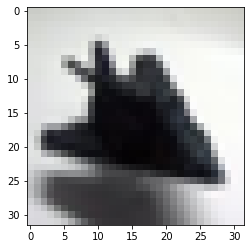

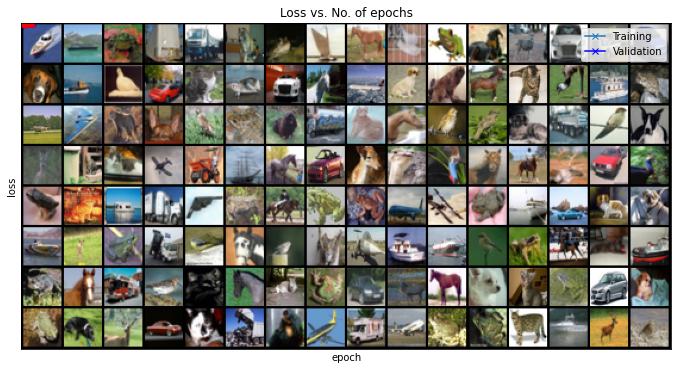

In [3]:
def main():
  
    # Download the dataset
    dataset_url = "https://s3.amazonaws.com/fast-ai-imageclas/cifar10.tgz"
    download_url(dataset_url, '.')

    # Extract from archive
    with tarfile.open('./cifar10.tgz', 'r:gz') as tar:
        tar.extractall(path='./data')

    # Look into the extracted folder
    data_dir = './data/cifar10'
    print(os.listdir(data_dir))                             # ['train', 'test']

    # Transform the training imagefolder to a pytorch tensor
    from torchvision.datasets import ImageFolder
    from torchvision.transforms import ToTensor
    dataset = ImageFolder(data_dir+'/train', transform=ToTensor())

    # Display the shape and label of the data
    import matplotlib
    import matplotlib.pyplot as plt
    matplotlib.rcParams['figure.facecolor'] = '#ffffff'
    img, label = dataset[0]
    print(img.shape, label)                                 # ([3, 32, 32]) 0

    # Dataset classes
    print(dataset.classes)                                  # ['airplane', 'automobile', '...']

    # Show the dataset
    def show_example(img, label):
        print('Label: ', dataset.classes[label], "("+str(label)+")")
        plt.imshow(img.permute(1, 2, 0))

    # The * sign unpack the tuple.dataset[0] instead of tuple (image, label)
    show_example(*dataset[0])

    # Set aside 5000 validation set from the training dataset
    # To ensure that we always create the same validation set, we'll also set a seed for the random number generator
    random_seed = 42
    torch.manual_seed(random_seed)
    val_size = 5000
    train_size = len(dataset) - val_size
    train_ds, val_ds = random_split(dataset, [train_size, val_size])

    print('train dataset:', len(train_ds))
    print('validation dataset:', len(val_ds))

    # Load the data in batches
    from torch.utils.data.dataloader import DataLoader
    batch_size = 128

    train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=4, pin_memory=True)
    val_dl = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
    print('Dataset loaded...')
    
    # Look at batches of images from the dataset using the make_grid method from torchvision
    from torchvision.utils import make_grid
    
    def show_batch(dl):
        for images, labels in dl:
            fig, ax = plt.subplots(figsize=(12, 6))
            ax.set_xticks([]); ax.set_yticks([])
            ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
            break
    
    show_batch(train_dl)
    
    ## Deep Convolutional Neural Network
    # Define ImageClassificationBase class which contains helper methods for training & validation

    class ImageClassificationBase(nn.Module):
        def training_step(self, batch):
            images, labels = batch
            out = self(images)  # Generate predictions
            loss = F.cross_entropy(out, labels)  # Calculate loss
            return loss

        def validation_step(self, batch):
            images, labels = batch
            out = self(images)  # Generate predictions
            loss = F.cross_entropy(out, labels)  # Calculate loss
            acc = accuracy(out, labels)  # Calculate accuracy
            return {'val_loss': loss.detach(), 'val_acc': acc}

        def validation_epoch_end(self, outputs):
            batch_losses = [x['val_loss'] for x in outputs]
            epoch_loss = torch.stack(batch_losses).mean()  # Combine losses
            batch_accs = [x['val_acc'] for x in outputs]
            epoch_acc = torch.stack(batch_accs).mean()  # Combine accuracies
            return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

        def epoch_end(self, epoch, result):
            print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
                epoch, result['train_loss'], result['val_loss'], result['val_acc']))

    def accuracy(outputs, labels):
        _, preds = torch.max(outputs, dim=1)
        return torch.tensor(torch.sum(preds == labels).item() / len(preds))

    # Use nn.Sequential to chain the layers and activation functions into a single network architecture

    class Cifar10CnnModel(ImageClassificationBase):
        def __init__(self):
            super().__init__()
            self.network = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, padding=1),
                nn.ReLU(),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # output: 64 x 16 x 16

                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # output: 128 x 8 x 8

                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(),
                nn.MaxPool2d(2, 2),  # output: 256 x 4 x 4

                nn.Flatten(),
                nn.Linear(256 * 4 * 4, 1024),
                nn.ReLU(),
                nn.Linear(1024, 512),
                nn.ReLU(),
                nn.Linear(512, 10))

        def forward(self, xb):
            return self.network(xb)

    model = Cifar10CnnModel()
    model

    # To seamlessly use a GPU, if one is available

    def get_default_device():
        """Pick GPU if available, else CPU"""
        if torch.cuda.is_available():
            return torch.device('cuda')
        else:
            return torch.device('cpu')

    def to_device(data, device):
        """Move tensor(s) to chosen device"""
        if isinstance(data, (list, tuple)):
            return [to_device(x, device) for x in data]
        return data.to(device, non_blocking=True)

    class DeviceDataLoader():
        """Wrap a dataloader to move data to a device"""

        def __init__(self, dl, device):
            self.dl = dl
            self.device = device

        def __iter__(self):
            """Yield a batch of data after moving it to device"""
            for b in self.dl:
                yield to_device(b, self.device)

        def __len__(self):
            """Number of batches"""
            return len(self.dl)

    device = get_default_device()
    print(device)

    train_dl = DeviceDataLoader(train_dl, device)
    val_dl = DeviceDataLoader(val_dl, device)
    to_device(model, device)

    # Train Model
    @torch.no_grad()
    def evaluate(model, val_loader):
        model.eval()
        outputs = [model.validation_step(batch) for batch in val_loader]
        return model.validation_epoch_end(outputs)

    def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
        history = []
        optimizer = opt_func(model.parameters(), lr)
        for epoch in range(epochs):
            # Training Phase
            model.train()
            train_losses = []
            for batch in train_loader:
                loss = model.training_step(batch)
                train_losses.append(loss)
                loss.backward()
                optimizer.step()
                optimizer.zero_grad()
            # Validation phase
            result = evaluate(model, val_loader)
            result['train_loss'] = torch.stack(train_losses).mean().item()
            model.epoch_end(epoch, result)
            history.append(result)
        return history

    model = to_device(Cifar10CnnModel(), device)
    evaluate(model, val_dl)

    # hyperparmeters (learning rate, no. of epochs, batch_size etc.) to train our model
    num_epochs = 10
    opt_func = torch.optim.Adam
    lr = 0.001

    history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

    # plot the validation set accuracies
    def plot_accuracies(history):
        accuracies = [x['val_acc'] for x in history]
        plt.plot(accuracies, '-x')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.title('Accuracy vs. No. of epochs')

    plot_accuracies(history)

    # more powerful model is suggested to get more efficiency
    # plot the training and validation losses to study the trend.
    def plot_losses(history):
        train_losses = [x.get('train_loss') for x in history]
        val_losses = [x['val_loss'] for x in history]
        plt.plot(train_losses, '-bx')
        plt.plot(val_losses, '-rx')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend(['Training', 'Validation'])
        plt.title('Loss vs. No. of epochs')

    plot_losses(history)

    # Test model
    test_dataset = ImageFolder(data_dir + '/test', transform=ToTensor())

    def predict_image(img, model):
        # Convert to a batch of 1
        xb = to_device(img.unsqueeze(0), device)
        # Get predictions from model
        yb = model(xb)
        # Pick index with highest probability
        _, preds = torch.max(yb, dim=1)
        # Retrieve the class label
        return dataset.classes[preds[0].item()]

    test_loader = DeviceDataLoader(DataLoader(test_dataset, batch_size * 2), device)
    result = evaluate(model, test_loader)
    result

    # the weights and bias of the model can be saved and used on another model using .state_dict method.

if __name__ == '__main__':
    main()